In [ ]:
# Code 1

In [1]:
import sounddevice as sd

print(sd.query_devices())

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone (USB PnP Sound Devic, MME (1 in, 0 out)
   2 Microphone (USB PnP Sound Devic, MME (1 in, 0 out)
   3 Microphone (Realtek(R) Audio), MME (2 in, 0 out)
   4 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  5 Speakers (Realtek(R) Audio), MME (0 in, 2 out)
   6 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   7 Microphone (USB PnP Sound Device), Windows DirectSound (1 in, 0 out)
   8 Microphone (USB PnP Sound Device), Windows DirectSound (1 in, 0 out)
   9 Microphone (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  10 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
  11 Speakers (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
  12 Speakers (Realtek(R) Audio), Windows WASAPI (0 in, 2 out)
  13 Microphone (USB PnP Sound Device), Windows WASAPI (1 in, 0 out)
  14 Microphone (Realtek(R) Audio), Windows WASAPI (2 in, 0 out)
  15 Microphone (USB PnP Sound Device), Windows WASAPI (1 

In [2]:
#Speak into one mic only this will help identify which mic is which
#LEFT MIC HAS WHITE DOT
#VERIFY MIC IDECIES

import pyaudio
import numpy as np

p = pyaudio.PyAudio()
fs = 44100  # Sample rate
chunk = 1024
seconds = 2  # Short test recording

for mic_index in [1, 2]:  # Replace with actual device indices
    print(f"Testing Microphone {mic_index}. Speak into it now...")
    
    stream = p.open(format=pyaudio.paInt16, channels=1, rate=fs, input=True, input_device_index=mic_index, frames_per_buffer=chunk)
    
    frames = []
    for _ in range(0, int(fs / chunk * seconds)):
        data = stream.read(chunk, exception_on_overflow=False)
        frames.append(np.frombuffer(data, dtype=np.int16))
    
    stream.stop_stream()
    stream.close()

    # Convert to numpy array and print summary
    audio_data = np.concatenate(frames)
    print(f"Microphone {mic_index} Average Amplitude: {np.mean(np.abs(audio_data))}\n")

p.terminate()


Testing Microphone 1. Speak into it now...
Microphone 1 Average Amplitude: 5540.791662881541

Testing Microphone 2. Speak into it now...
Microphone 2 Average Amplitude: 96.17234057049419



In [ ]:
#Code 2

In [4]:
#Record sound clip from both mics at the same time

import sounddevice as sd
import soundfile as sf
import numpy as np
import time

# Replace these with the correct indices you found
LEFT_MIC_INDEX = 1
RIGHT_MIC_INDEX = 2

DURATION = 1.0  # seconds
SAMPLERATE = 44100

# Buffer to hold both mic recordings
recordings = {}

# Record from both devices using threads
def record_from_device(index, key):
    recording = sd.rec(int(DURATION * SAMPLERATE), samplerate=SAMPLERATE, channels=1, device=index, dtype='float32')
    sd.wait()
    recordings[key] = recording.flatten()

# Start both recordings nearly simultaneously
from threading import Thread

t1 = Thread(target=record_from_device, args=(LEFT_MIC_INDEX, 'left'))
t2 = Thread(target=record_from_device, args=(RIGHT_MIC_INDEX, 'right'))

start_time = time.time()
t1.start(); t2.start()
t1.join(); t2.join()
print(f"Recording finished. Elapsed: {time.time() - start_time:.3f}s")

# Save to .wav files
sf.write('mic_left.wav', recordings['left'], SAMPLERATE)
sf.write('mic_right.wav', recordings['right'], SAMPLERATE)
print("Saved mic_left.wav and mic_right.wav")


Recording finished. Elapsed: 1.174s
Saved mic_left.wav and mic_right.wav


In [ ]:
#Code 3

In [5]:
#Determine correction factor
#To do so clap directly between the mics then run this chunk of code
#Manually add correlation factor into the rest of the code (this way it wont needed to be changed every time you run the code)

import numpy as np
import soundfile as sf
from scipy.signal import correlate

# Load recordings
left, sr = sf.read('mic_left.wav')
right, _ = sf.read('mic_right.wav')

# Ensure same length
min_len = min(len(left), len(right))
left = left[:min_len]
right = right[:min_len]

# Normalize both signals
left = (left - np.mean(left)) / np.std(left)
right = (right - np.mean(right)) / np.std(right)

# Cross-correlation to estimate delay
corr = correlate(left, right, mode='full')
lags = np.arange(-len(left) + 1, len(right))
offset = lags[np.argmax(corr)]

# Print the correction factor
print(f"Estimated correction factor (manual_offset_samples) = {offset} samples")

#postive value means left lags behind right
#Negative value means right lags behind left


Estimated correction factor (manual_offset_samples) = 267 samples


In [ ]:
#Code 4

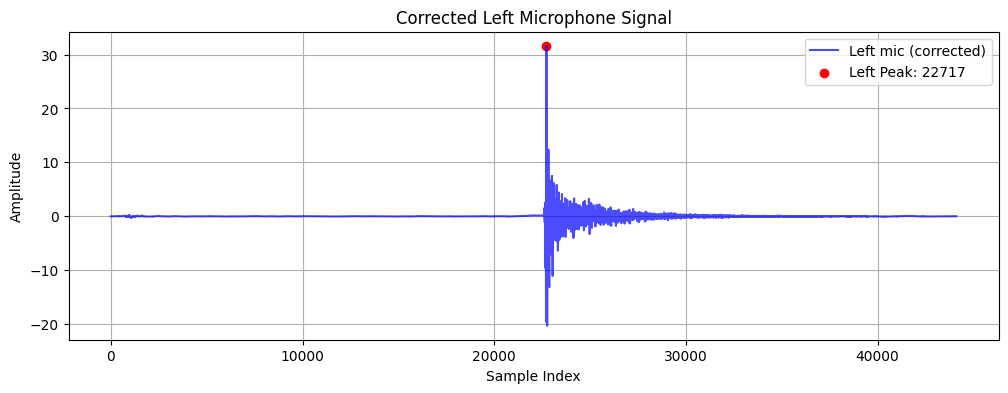

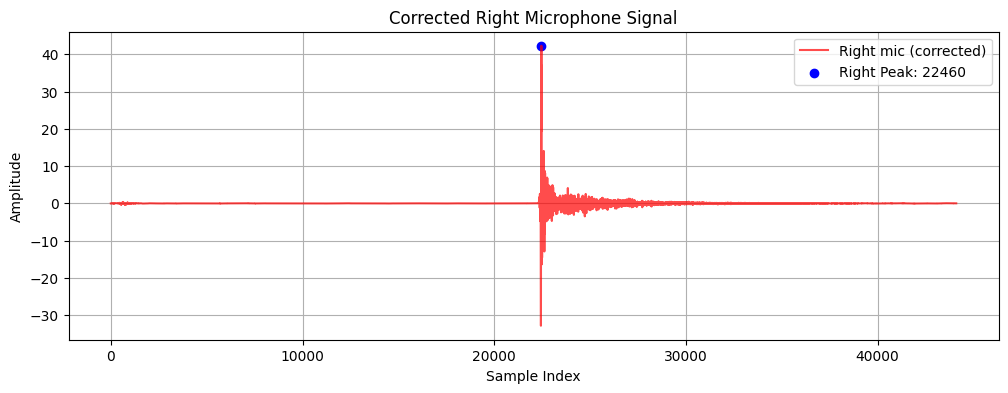

Left Peak Index: 22717
Right Peak Index: 22460


In [6]:
import matplotlib.pyplot as plt

# Manually set correction in samples (positive = left mic delayed)
manual_offset_samples = 0  # example value, adjust as needed

# Apply correction
if manual_offset_samples > 0:
    left_corr = left[manual_offset_samples:]
    right_corr = right[:len(left_corr)]
elif manual_offset_samples < 0:
    right_corr = right[-manual_offset_samples:]
    left_corr = left[:len(right_corr)]
else:
    left_corr = left
    right_corr = right

# Find peaks
left_peak_corr = np.argmax(np.abs(left_corr))
right_peak_corr = np.argmax(np.abs(right_corr))

# Plot Left mic (corrected)
plt.figure(figsize=(12, 4))
plt.plot(left_corr, label='Left mic (corrected)', alpha=0.7, color='blue')
plt.scatter(left_peak_corr, left_corr[left_peak_corr], color='red', label=f"Left Peak: {left_peak_corr}")
plt.legend()
plt.title("Corrected Left Microphone Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Plot Right mic (corrected)
plt.figure(figsize=(12, 4))
plt.plot(right_corr, label='Right mic (corrected)', alpha=0.7, color='red')
plt.scatter(right_peak_corr, right_corr[right_peak_corr], color='blue', label=f"Right Peak: {right_peak_corr}")
plt.legend()
plt.title("Corrected Right Microphone Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Print Peak Index Locations
print(f"Left Peak Index: {left_peak_corr}")
print(f"Right Peak Index: {right_peak_corr}")


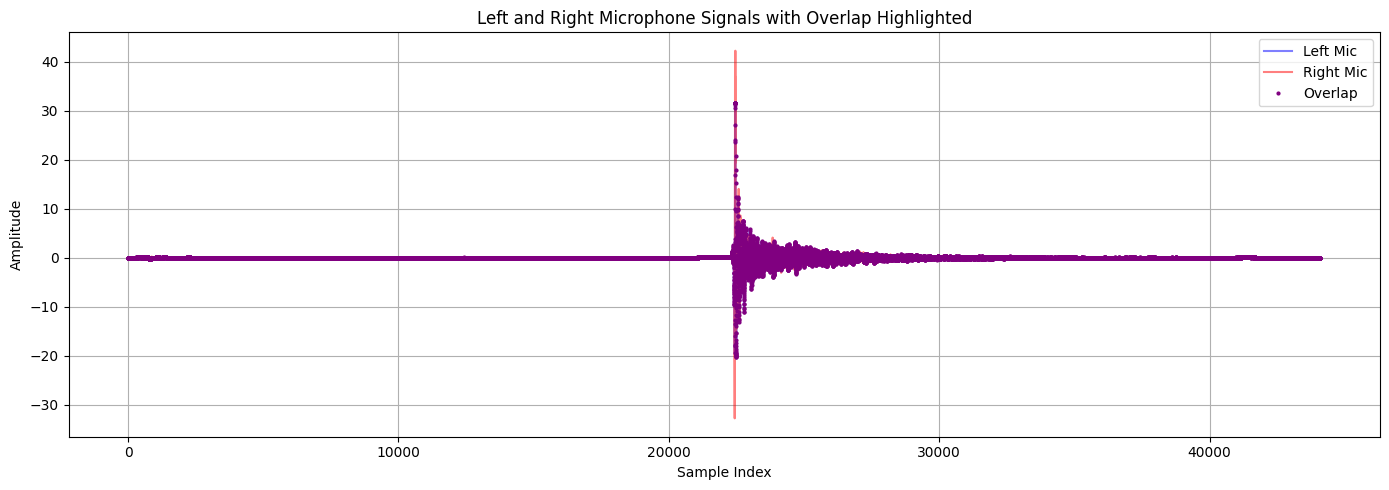

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure left_corr and right_corr are same length
min_len = min(len(left_corr), len(right_corr))
left_trimmed = left_corr[:min_len]
right_trimmed = right_corr[:min_len]

# Create x-axis
x = np.arange(min_len)

# Define overlap threshold (amplitude difference)
threshold = 100  # Adjust as needed for your signal scale

# Boolean mask for overlap
overlap_mask = np.abs(left_trimmed - right_trimmed) < threshold

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(x, left_trimmed, label='Left Mic', color='blue', alpha=0.5)
plt.plot(x, right_trimmed, label='Right Mic', color='red', alpha=0.5)

# Highlight overlapping samples
plt.plot(x[overlap_mask], left_trimmed[overlap_mask], 'o', color='purple', markersize=2, label='Overlap')

plt.title("Left and Right Microphone Signals with Overlap Highlighted")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Code 5

In [8]:
# Apply manual correction
manual_offset_samples = -267  # replace `offset` with your saved value Negative shifts left index back
left_corr = np.roll(left, manual_offset_samples)
right_corr = right

# Peak detection after manual correction
left_peak_corr = np.argmax(np.abs(left_corr))
right_peak_corr = np.argmax(np.abs(right_corr))

# Constants
SAMPLERATE = 48000
v_sound_cm_s = 34300
mic_distance_cm = 37.465

# Time Difference of Arrival (based on corrected peak indices)
tdoa = (left_peak_corr - right_peak_corr) / SAMPLERATE
distance_diff_cm = round(tdoa * v_sound_cm_s)  # rounded to nearest cm

# Determine which mic is closer
if left_peak_corr < right_peak_corr:
    closer_mic = "Left"
elif right_peak_corr < left_peak_corr:
    closer_mic = "Right"
else:
    closer_mic = "Same"

# Output
print(f"Corrected Left Peak Index: {left_peak_corr}, Right Peak Index: {right_peak_corr}")
print(f"Sound is closer to the {closer_mic} mic.")
print(f"Estimated distance difference: {abs(distance_diff_cm)} cm")


Corrected Left Peak Index: 22450, Right Peak Index: 22460
Sound is closer to the Left mic.
Estimated distance difference: 7 cm
